In [38]:
#Import needed packages
import torch
import torch.nn as nn
from torchvision.datasets import CIFAR10
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.autograd import Variable
import numpy as np
import os
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset
from PIL import Image
import torch.nn.functional as F
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import PIL 

In [39]:
class SimpleNet(nn.Module):
    def __init__(self, num_classes=3):
        super(SimpleNet, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        
        
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()

        self.pool = nn.MaxPool2d(kernel_size=3)

        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.relu3 = nn.ReLU()

        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.relu4 = nn.ReLU()

        self.fc = nn.Linear(in_features=2 * 2 * 128, out_features=num_classes)

    def forward(self, input):
        output = self.conv1(input)
        output = self.relu1(output)
#         print('shape after convolution ' + str(output.shape))
        output = self.pool(output)
#         print('shape after POOL ' + str(output.shape))
        output = self.conv2(output)
        output = self.relu2(output)
#         print('shape after convolution ' + str(output.shape))
        output = self.pool(output)
#         print('shape after POOL ' + str(output.shape))
        output = self.conv3(output)
        output = self.relu3(output)
#         print('shape after convolution ' + str(output.shape))
        output = self.pool(output)
#         print('shape after POOL ' + str(output.shape))
        output = self.conv4(output)
        
#         print('shape after convolution ' + str(output.shape))
        output = self.relu4(output)
#         print('shape before linear  ' + str(output.shape))
        output = self.pool(output)
#         print('shape after POOL ' + str(output.shape))
        output = output.view(output.size(0),-1)
#         print('shape after linear ' + str(output.shape))

        output = self.fc(output)

        return output

In [40]:
# #___LOAD DATA

#___PATH
BASE_PATH="/home/codepython/tensor_flow/Poacher_augmented_images/"

image=[]
labels=[]
for file in os.listdir(BASE_PATH):
    if file=='PAA':
        for c in os.listdir(os.path.join(BASE_PATH, file)):
            if c!='annotations':
                image.append(c)
                labels.append('Poacher with Arrow')
    if file=='PGA':
        for c in os.listdir(os.path.join(BASE_PATH, file)):
            if c!='annotations':
                image.append(c)
                labels.append('Poacher with Gun')
    if file=='NPA':
        for c in os.listdir(os.path.join(BASE_PATH, file)):
            if c!='annotations':
                image.append(c)
                labels.append('No Poacher')

data = {'Images':image, 'labels':labels} 
data = pd.DataFrame(data) 
#data.head()


lb = LabelEncoder()
data['encoded_labels'] = lb.fit_transform(data['labels'])
data.head()

,Images,labels,encoded_labels
0,No_Poacher_0_101.jpg,Poacher with Gun,2
1,No_Poacher_0_3749.jpg,Poacher with Gun,2
2,No_Poacher_0_571.jpg,Poacher with Gun,2
3,No_Poacher_0_2206.jpg,Poacher with Gun,2
4,No_Poacher_0_724.jpg,Poacher with Gun,2


In [41]:
transform = transforms.Compose([
        #transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))])

#____POACHER___DATASET
class Poacher_Dataset(Dataset):
    def __init__(self, img_data,img_path,transform=None):
        self.img_path = img_path
        self.transform = transform
        self.img_data = img_data
        
        
    def __len__(self):
        return len(self.img_data)
    
    def __getitem__(self, index):
        img_name = os.path.join(self.img_path,self.img_data.loc[index, 'labels'],
                                self.img_data.loc[index, 'Images'])
        image = Image.open(img_name)
        image=np.array(image)
#         R, G, B = image[:,:,0], image[:,:,1], image[:,:,2]
#         image=0.2989 * R + 0.5870 * G + 0.1140 * B#### Convert image to gray scale

        label = torch.tensor(self.img_data.loc[index, 'encoded_labels'])
        if self.transform is not None:
#             image=torch.from_numpy(image).long()
            image = self.transform(image)
        return image, label

In [42]:
batch_size = 32
validation_split = .3
shuffle_dataset = True
random_seed= 42

dataset_size = len(data)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
    
train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)



#Define transformations for the training set, flip the images randomly, crop out and apply mean and std normalization
train_transformations = transforms.Compose([
     #transforms.Resize(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32,padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

In [43]:
#Create model, optimizer and loss function
model = SimpleNet(num_classes=3)

dataset = Poacher_Dataset(data,BASE_PATH,transform)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                           sampler=train_sampler)
test_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                sampler=valid_sampler)

# model=SimpleNet()
optimizer = Adam(model.parameters(), lr=0.001,weight_decay=0.0001)

loss_fn= nn.CrossEntropyLoss()




In [44]:
#Create a learning rate adjustment function that divides the learning rate by 10 every 30 epochs
def adjust_learning_rate(epoch):

    lr = 0.001

    if epoch > 180:
        lr = lr / 1000000
    elif epoch > 150:
        lr = lr / 100000
    elif epoch > 120:
        lr = lr / 10000
    elif epoch > 90:
        lr = lr / 1000
    elif epoch > 60:
        lr = lr / 100
    elif epoch > 30:
        lr = lr / 10

    for param_group in optimizer.param_groups:
        param_group["lr"] = lr

In [45]:
import time

def train(model, optimizer, loss_fn, train_loader, test_loader, epochs=20, device='cpu'):

    print('train() called: model=%s, opt=%s(lr=%f), epochs=%d, device=%s\n' % \
          (type(model).__name__, type(optimizer).__name__,
           optimizer.param_groups[0]['lr'], epochs, device))

    history = {} # Collects per-epoch loss and acc like Keras' fit().
    history['loss'] = []
    history['val_loss'] = []
    history['acc'] = []
    history['val_acc'] = []

    start_time_sec = time.time()

    for epoch in range(1, epochs+1):

        # --- TRAIN AND EVALUATE ON TRAINING SET -----------------------------
        model.train()
        train_loss         = 0.0
        num_train_correct  = 0
        num_train_examples = 0

        for batch in train_loader:

            optimizer.zero_grad()

            x    = batch[0].to(device)
            y    = batch[1].to(device)
            yhat = model(x)
            loss = loss_fn(yhat, y)

            loss.backward()
            optimizer.step()

            train_loss         += loss.data.item() * x.size(0)
            num_train_correct  += (torch.max(yhat, 1)[1] == y).sum().item()
            num_train_examples += x.shape[0]

        train_acc   = num_train_correct / num_train_examples
        train_loss  = train_loss / len(train_loader.dataset)


        # --- EVALUATE ON VALIDATION SET -------------------------------------
        model.eval()
        val_loss       = 0.0
        num_val_correct  = 0
        num_val_examples = 0

        for batch in test_loader:

            x    = batch[0].to(device)
            y    = batch[1].to(device)
            yhat = model(x)
            loss = loss_fn(yhat, y)

            val_loss         += loss.data.item() * x.size(0)
            num_val_correct  += (torch.max(yhat, 1)[1] == y).sum().item()
            num_val_examples += y.shape[0]

        val_acc  = num_val_correct / num_val_examples
        val_loss = val_loss / len(test_loader.dataset)


        if epoch == 1 or epoch % 2 == 0:
          print('Epoch %3d/%3d, train loss: %5.2f, train acc: %5.2f, val loss: %5.2f, val acc: %5.2f' % \
                (epoch, epochs, train_loss, train_acc, val_loss, val_acc))

        history['loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['acc'].append(train_acc)
        history['val_acc'].append(val_acc)

    # END OF TRAINING LOOP


    end_time_sec       = time.time()
    total_time_sec     = end_time_sec - start_time_sec
    time_per_epoch_sec = total_time_sec / epochs
    print()
    print('Time total:     %5.2f sec' % (total_time_sec))
    print('Time per epoch: %5.2f sec' % (time_per_epoch_sec))

    return history

In [46]:
history = train(
    model = model,
    optimizer = optimizer,
    loss_fn = loss_fn,
    train_loader = train_loader,
    test_loader = test_loader,
    device='cpu')

train() called: model=SimpleNet, opt=Adam(lr=0.001000), epochs=20, device=cpu

Epoch   1/ 20, train loss:  0.56, train acc:  0.64, val loss:  0.23, val acc:  0.65
Epoch   2/ 20, train loss:  0.45, train acc:  0.71, val loss:  0.19, val acc:  0.70
Epoch   4/ 20, train loss:  0.34, train acc:  0.80, val loss:  0.15, val acc:  0.78
Epoch   6/ 20, train loss:  0.22, train acc:  0.88, val loss:  0.11, val acc:  0.86
Epoch   8/ 20, train loss:  0.16, train acc:  0.91, val loss:  0.11, val acc:  0.85
Epoch  10/ 20, train loss:  0.10, train acc:  0.94, val loss:  0.11, val acc:  0.86
Epoch  12/ 20, train loss:  0.04, train acc:  0.98, val loss:  0.09, val acc:  0.89
Epoch  14/ 20, train loss:  0.05, train acc:  0.97, val loss:  0.07, val acc:  0.93
Epoch  16/ 20, train loss:  0.03, train acc:  0.99, val loss:  0.08, val acc:  0.92
Epoch  18/ 20, train loss:  0.01, train acc:  1.00, val loss:  0.09, val acc:  0.92
Epoch  20/ 20, train loss:  0.00, train acc:  1.00, val loss:  0.08, val acc:  0.

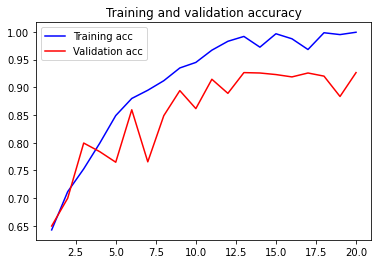

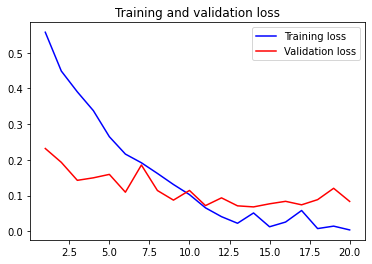

In [47]:
acc = history['acc']
val_acc = history['val_acc']
loss = history['loss']
val_loss = history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
train_accu=[]
train_losses=[]
def train(num_epochs):
    
    for epoch in range(num_epochs):
        print('\nEpoch : %d'%epoch)
    
        model.train()

        running_loss=0
        correct=0
        total=0
        #exp_lr_scheduler.step()

        for batch_idx, (data, target) in enumerate(train_loader):
    #         data,target=data[0].to(device),data[1].to(device)
            data, target = Variable(data), Variable(target)

    #         if torch.cuda.is_available():
    #             data = data.cuda()
    #             target = target.cuda()

            optimizer.zero_grad()


            output = model(data)

            loss = loss_fn(output, target)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()

        train_loss=running_loss/len(train_loader)
        accu=100.*correct/total

        train_accu.append(accu)
        train_losses.append(train_loss)
        print('Train Loss: %.3f | Accuracy: %.3f'%(train_loss,accu))
        if (batch_idx + 1)% 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, (batch_idx + 1) * len(data), len(train_loader.dataset),
                100. * (batch_idx + 1) / len(train_loader), loss.data))

#Accuracy is the number of correct classifications / the total amount of classifications.
#I am dividing it by the total number of the dataset because I have finished one epoch.
#If you would like to calculate the loss for each epoch, divide 
the running_loss by the number of batches and append it to train_losses in each epoch.        